In [2]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
# from cdo import *
# cdo = Cdo()

from metpy.units import units
# from LinearRegression import linear_regression
# import cdstoolbox as ct

dir_input = '/work/mh0033/m301036/LSAT/Data/Regrid/'

data_CRUTEMP  = dir_input+'tas_CRUTEMP_regrid.nc'
data_MLOST    = dir_input+'tas_MLOST_regrid.nc'
data_GISSTEMP = dir_input+'tas_GISS_regrid.nc'

In [3]:
#Using dateTime to select key period
#Using dateTime to select key period
tas_GISS    = xr.open_dataset(data_GISSTEMP)
tas_CRUTEMP = xr.open_dataset(data_CRUTEMP) 
tas_MLOST   = xr.open_dataset(data_MLOST,decode_times=False)
units, reference_data = tas_MLOST.time.attrs['units'].split('since')
display(tas_MLOST.time)

tas_CRUTEMP = tas_CRUTEMP.astype(np.float64)
# display(tas_GISS)
# display(tas_CRUTEMP)
# display(tas_MLOST)
# display(tas_GHCNv4)

tas_CRUTEMP = tas_CRUTEMP-273.15
# tas_MLOST_sel = tas_MLOST_sel-273.15
tas_MLOST

<xarray.DataArray 'time' (time: 2079)>
array([18262., 18293., 18321., ..., 81449., 81480., 81508.])
Coordinates:
  * time     (time) float64 1.826e+04 1.829e+04 ... 8.148e+04 8.151e+04
Attributes:
    standard_name:  time
    long_name:      Time
    bounds:         time_bnds
    units:          days since 1800-1-1 00:00:0.0
    calendar:       gregorian
    axis:           T

<xarray.Dataset>
Dimensions:    (time: 2079, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) float64 1.826e+04 1.829e+04 ... 8.148e+04 8.151e+04
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    air        (time, lat, lon) float32 ...
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    Conventions:           CF-1.0
    source:                https://www.ncdc.noaa.gov/noaa-merged-land-ocean-g...
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    ...                    ...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Wed May 24 15:21:45 2023: cdo remapbil,r180x90 /wo...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

In [4]:
#---------------------------------------------------------------------------
# Function to calculate the running mean
# The Savitzky-Golay filter uses convolution process applied on an array for
# smoothing. The Python package scipy provide the function as shown in the
# next example.
#---------------------------------------------------------------------------
def calc_running_mean(data, window_length=20, polyorder=3, mode='nearest'):
    return scipy.signal.savgol_filter(data,
                                      window_length,
                                      polyorder,
                                      mode='nearest')

In [5]:
tas_MLOST_recon = pd.to_datetime(tas_MLOST.time.data, unit='D', origin=pd.Timestamp('1800-01-01'))
tas_MLOST_recon

DatetimeIndex(['1850-01-01', '1850-02-01', '1850-03-01', '1850-04-01',
               '1850-05-01', '1850-06-01', '1850-07-01', '1850-08-01',
               '1850-09-01', '1850-10-01',
               ...
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01'],
              dtype='datetime64[ns]', length=2079, freq=None)

In [6]:
tas_MLOST = tas_MLOST.assign_coords({"time":(tas_MLOST_recon)})
tas_MLOST

<xarray.Dataset>
Dimensions:    (time: 2079, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    air        (time, lat, lon) float32 ...
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    Conventions:           CF-1.0
    source:                https://www.ncdc.noaa.gov/noaa-merged-land-ocean-g...
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    ...                    ...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Wed May 24 15:21:45 2023: cdo remapbil,r180x90 /wo...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

In [7]:
#Land only dataset
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

In [8]:
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=tas_MLOST['time'], method='nearest')

# Apply the land-sea mask to the original dataset

masked_MLOST_tas = tas_MLOST.where(mask_data == 1, drop=False)

# Print the resulting masked dataset
masked_MLOST_tas

<xarray.Dataset>
Dimensions:    (time: 2079, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds, lat, lon) float64 1.826e+04 1.826e+04 ... nan nan
    air        (time, lat, lon) float32 -0.1726 -0.1726 -0.1726 ... nan nan nan
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    Conventions:           CF-1.0
    source:                https://www.ncdc.noaa.gov/noaa-merged-land-ocean-g...
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    ...                    ...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Wed May 24 15:21:45 2023: cdo remapbil,r180x90 /wo...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

In [9]:
tas_MLOST_annual   = masked_MLOST_tas['air'].loc['1958-01-01':'2022-12-31',0:90,:]
tas_MLOST_annual

<xarray.DataArray 'air' (time: 780, lat: 45, lon: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2022-12-01
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
Attributes:
    standard_name:          air_temperature_anomaly
    long_name:              Surface Air Temperature and SST Monthly Anomaly
    units:                  degC
    var_desc:               Air Temperature
    level_desc:             Surface
    statistic:              Anomaly
    parent_stat:            Observation
    precision:              2
    cell_methods:           time: anomaly (monthly from values)
    dataset:                NOAA Global Temperature
    date_of_file_acquired:  2020-5-4
    actual_range:           [-20.1062  25.29  ]

In [10]:
tas_MLOST_ano    = tas_MLOST_annual-tas_MLOST_annual.mean()
year = np.arange(1958,2023,1)
lat = tas_MLOST_ano['lat']
lon = tas_MLOST_ano['lon']

In [11]:
tas_MLOST_annual   = tas_MLOST_ano.groupby('time.year').mean()
tas_MLOST_annual_mean =tas_MLOST_annual.mean(dim='year')
tas_MLOST_annual

<xarray.DataArray 'air' (year: 65, lat: 45, lon: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
  * year     (year) int64 1958 1959 1960 1961 1962 ... 2018 2019 2020 2021 2022

In [12]:
from scipy.stats import linregress

# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values
mask_data = mask_data.reindex(time=tas_MLOST_ano['time'], method='nearest')

#Calculate the spatial trend pattern of the annual mean temperature
slope1 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
intercept1 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
r1 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
p1 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
se1 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))

for i in np.arange(tas_MLOST_ano.shape[1]):
    for j in np.arange(tas_MLOST_ano.shape[2]):

        # Calculate the linear trend for each grid point
        slope1[i, j], intercept1[i, j], r1[i, j], p1[i, j], se1[i, j] = linregress(year, tas_MLOST_annual[:, i, j])

# Create a masked array for the trend data
trend_data = xr.DataArray(slope1*65, coords=[lat, lon], dims=['lat', 'lon'])
ci_data = xr.DataArray(p1, coords=[lat, lon], dims=['lat', 'lon'])
# # Create a masked array for the trend data
# trend_data = xr.DataArray(slope1, coords=[lat, lon], dims=['lat', 'lon'])

# Create a masked array for the significant trend values
sig_trend_data = trend_data.where(p1 < 0.05)

# Print the resulting trend pattern
print(sig_trend_data.min().values, sig_trend_data.max().values)
# Print the resulting trend pattern
print(trend_data.min().values)
# print(ci_data.min().values)

0.6272287740847043 5.000864000091414
0.6272287740847043


In [13]:
tas_MLOST_DJF    = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([12,1,2])].loc['1958-12-01':'2022-03-01']
tas_MLOST_MAM    = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([3,4,5])]
tas_MLOST_JJA    = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([6,7,8])]
tas_MLOST_SON    = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([9,10,11])]
tas_MLOST_DJF, tas_MLOST_MAM

(<xarray.DataArray 'air' (time: 192, lat: 45, lon: 180)>
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
 ...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],

In [14]:
tas_MLOST_DJF_mean = tas_MLOST_DJF.groupby('time.year').mean()
tas_MLOST_MAM_mean = tas_MLOST_MAM.groupby('time.year').mean()
tas_MLOST_JJA_mean = tas_MLOST_JJA.groupby('time.year').mean()
tas_MLOST_SON_mean = tas_MLOST_SON.groupby('time.year').mean()

In [15]:
tas_MLOST_DJF_mean

<xarray.DataArray 'air' (year: 65, lat: 45, lon: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
  * year     (year) int64 1958 1959 1960 1961 1962 ... 2018 2019 2020 2021 2022

In [16]:
tas_MLOST_DJF.min().values, tas_MLOST_MAM.min().values, tas_MLOST_JJA.min().values, tas_MLOST_SON.min().values

(array(-15.28578758),
 array(-13.94382668),
 array(-6.09478378),
 array(-12.86093235))

In [17]:
#Calculate the spatial trend pattern of the annual mean temperature
slope2 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
intercept2 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
r2 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
p2 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
se2 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))

for i in np.arange(tas_MLOST_ano.shape[1]):
    for j in np.arange(tas_MLOST_ano.shape[2]):

        # Calculate the linear trend for each grid point
        slope2[i, j], intercept2[i, j], r2[i, j], p2[i, j], se2[i, j] = linregress(year, tas_MLOST_DJF_mean[:, i, j])

# Create a masked array for the trend data
trend_DJF_data = xr.DataArray(slope2*65, coords=[lat, lon], dims=['lat', 'lon'])
ci_DJF_data = xr.DataArray(p2, coords=[lat, lon], dims=['lat', 'lon'])

print(trend_DJF_data.min().values, trend_DJF_data.max().values)

-0.06413470271085822 7.892902126493441


In [18]:
slope3 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
intercept3 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
r3 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
p3 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
se3 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))

for i in np.arange(tas_MLOST_ano.shape[1]):
    for j in np.arange(tas_MLOST_ano.shape[2]):

        # Calculate the linear trend for each grid point
        slope3[i, j], intercept3[i, j], r3[i, j], p3[i, j], se3[i, j] = linregress(year, tas_MLOST_MAM_mean[:, i, j])

# Create a masked array for the trend data
trend_MAM_data = xr.DataArray(slope3*65, coords=[lat, lon], dims=['lat', 'lon'])
ci_MAM_data = xr.DataArray(p3, coords=[lat, lon], dims=['lat', 'lon'])

print(trend_MAM_data.min().values, trend_MAM_data.max().values)

0.5097375610441139 5.959791783264584


In [19]:
slope4 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
intercept4 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
r4 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
p4 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
se4 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))

for i in np.arange(tas_MLOST_ano.shape[1]):
    for j in np.arange(tas_MLOST_ano.shape[2]):

        # Calculate the linear trend for each grid point
        slope4[i, j], intercept4[i, j], r4[i, j], p4[i, j], se4[i, j] = linregress(year, tas_MLOST_JJA_mean[:, i, j])

# Create a masked array for the trend data
trend_JJA_data = xr.DataArray(slope4*65, coords=[lat, lon], dims=['lat', 'lon'])
ci_JJA_data = xr.DataArray(p4, coords=[lat, lon], dims=['lat', 'lon'])

print(trend_JJA_data.min().values, trend_JJA_data.max().values)

0.14271318010287348 3.518648062515157


In [20]:
slope5 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
intercept5 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
r5 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
p5 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))
se5 = np.zeros((tas_MLOST_ano.shape[1], tas_MLOST_ano.shape[2]))

for i in np.arange(tas_MLOST_ano.shape[1]):
    for j in np.arange(tas_MLOST_ano.shape[2]):

        # Calculate the linear trend for each grid point
        slope5[i, j], intercept5[i, j], r5[i, j], p5[i, j], se5[i, j] = linregress(year, tas_MLOST_SON_mean[:, i, j])

# Create a masked array for the trend data
trend_SON_data = xr.DataArray(slope5*65, coords=[lat, lon], dims=['lat', 'lon'])
ci_SON_data = xr.DataArray(p5, coords=[lat, lon], dims=['lat', 'lon'])

print(trend_SON_data.min().values, trend_SON_data.max().values)

0.6183705543252555 5.908628698988733


/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)
/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = super().pcolormesh(*args, **kwargs)
/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is d

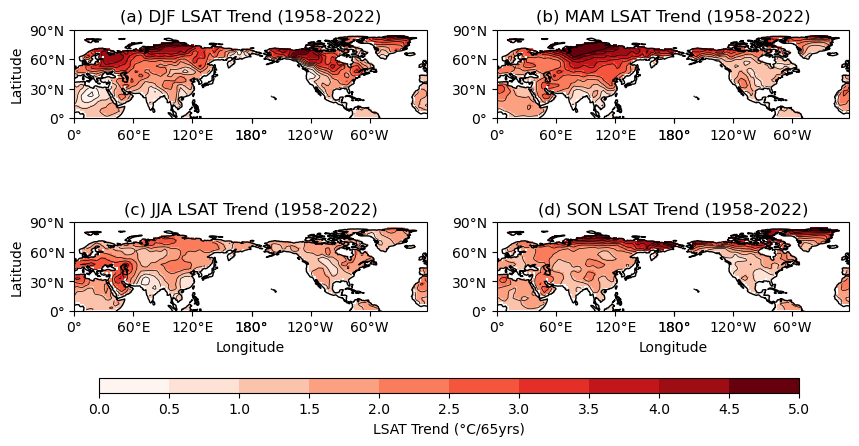

In [21]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from matplotlib.colors import BoundaryNorm, ListedColormap

# Create a new figure and axis
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.0015) #,

# Define the levels and colormap
levels = np.arange(0, 5.5, 0.5)
cmap = plt.cm.get_cmap('Reds', len(levels) - 1)

# Plot the trend data on the map for each season
for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    # Create a new axis for each season
    ax = fig.add_subplot(gs[i], projection=ccrs.PlateCarree(central_longitude=180))

    # Plot the trend data on the map
    trend_data = globals()[f'trend_{season}_data']
    # sig_trend_data = trend_data.where( globals()[f'ci_{season}_data'] < 0.10)
    im = ax.pcolormesh(trend_data.lon, trend_data.lat, trend_data, transform=ccrs.PlateCarree(), cmap=cmap, vmin=0., vmax=5.0, norm=BoundaryNorm(levels, ncolors=cmap.N, clip=True))
    contours = ax.contour(trend_data.lon, trend_data.lat, trend_data, transform=ccrs.PlateCarree(), levels=levels, colors='black', linewidths=0.5)

    # im = ax.pcolormesh(sig_trend_data.lon, sig_trend_data.lat, sig_trend_data, transform=ccrs.PlateCarree(), cmap=cmap, vmin=0., vmax=5.0, norm=BoundaryNorm(levels, ncolors=cmap.N, clip=True))
    # contours = ax.contour(sig_trend_data.lon, sig_trend_data.lat, sig_trend_data, transform=ccrs.PlateCarree(), levels=levels, colors='black', linewidths=0.5)

    # Add coastlines and a colorbar
    ax.coastlines()

    # Add latitude and longitude labels to the x and y axes
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Remove x label for upper plots and y label for right plots
    if i in [0, 1]:
        ax.set_xlabel('')
    if i in [1, 3]:
        ax.set_ylabel('')

    # Set the title of the plot
    plt.title(f'({chr(97+i)}) {season} LSAT Trend (1958-2022)')

# Add colorbar
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
cbar = plt.colorbar(im, cax=cbar_ax, cmap=cmap, orientation='horizontal', ticks=levels)
cbar.ax.set_xlabel('LSAT Trend (°C/65yrs)')

# Save the figure
plt.savefig('tas_MLOST_1958-2022_trend.png', dpi=300, bbox_inches='tight')
